# IMports

In [491]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import seaborn as sns

In [492]:
# =============================================================================
# 1. CONFIGURACIÓN: Flags para incluir componentes (puedes activar o desactivar)
# =============================================================================
incluir_inversiones = True         # Incluir inversiones agrupadas (Internet, Plataformas, Cine, Otros)
incluir_outcome_lag   = True         # Incluir el outcome rezagado (Yₜ₋₁)
incluir_mercado       = True         # Incluir Mercado (convertido a porcentaje)
incluir_naturalsearch = True         # Incluir NaturalSearch
incluir_directtraffic = True         # Incluir DirectTraffic
incluir_easterweek    = True         # Incluir Easterweek
incluir_weekend       = True         # Incluir WeekendDays (fines de semana)
incluir_xmas          = True         # Incluir dummy para Navidad

# Define el target; en este ejemplo, predecimos "Visit_Store" (tráfico físico)
target = "Conversion"

# LOAD DATA

In [493]:
# =============================================================================
# 2. CARGA DE DATOS Y PIVOT
# =============================================================================
# Cargamos el JSON directamente en un DataFrame
df = pd.read_json('jsonclean/fulldata.json')

# Dado que el JSON tiene la forma: {Category: {timestamp: value}},
# transformamos la estructura a formato largo y luego lo pivotamos para que cada categoría sea una columna.
filas = []
for categoria, dic in df.to_dict().items():
    for ts, val in dic.items():
        filas.append({'timestamp': pd.to_datetime(ts, unit='ms'),
                      'Category': categoria,
                      'value': val})
df_largo = pd.DataFrame(filas)
df_largo = df_largo.sort_values('timestamp')
df_largo = df_largo.set_index('timestamp')
df_pivot = df_largo.pivot_table(index=df_largo.index, columns='Category', values='value', aggfunc='sum')
# Ahora, cada columna corresponde a una categoría (p.ej. "CINE", "INTERNET", etc.)

# CREATE dfs

# 4 channels

In [494]:
# =============================================================================
# 3. CREAR VARIABLES BASE
# =============================================================================
# --- Inversiones publicitarias agrupadas ---
if incluir_inversiones:
    # Se agrupan en 4 grupos:
    # Internet: de "INTERNET"
    # Plataformas: de "PlataformasVideo"
    # Cine: de "CINE"
    # Otros: suma de "EXTERIOR", "PRENSA", "RADIO", "REVISTAS", "PRODUCCION", "VARIOS"
    df_inv = pd.DataFrame()
    df_inv['Internet']    = df_pivot['INTERNET']
    df_inv['Plataformas'] = df_pivot['PlataformasVideo']
    df_inv['Cine']        = df_pivot['CINE']
    df_inv['Otros']       = df_pivot[['EXTERIOR', 'PRENSA', 'RADIO', 'REVISTAS', 'PRODUCCION', 'VARIOS']].sum(axis=1)
    # Resample a datos mensuales (suma)
    df_inv = df_inv.sort_index().resample('M').sum()
    
    # Convertir cada canal a porcentaje del total de inversión en ese mes
    df_inv_pct = df_inv.div(df_inv.sum(axis=1), axis=0) * 100
    print("Inversiones agrupadas (en % mensuales):")
    print(df_inv_pct.head())

# --- Outcome y otras variables ---
df_visit_store = df_pivot['Visit_Store'].resample('M').sum().to_frame(name='Visit_Store')
df_sales       = df_pivot['Sales'].resample('M').sum().to_frame(name='Sales')
df_unique      = df_pivot['Unique_visitors'].resample('M').sum().to_frame(name='Unique_visitors')

# Para "Mercado", lo convertimos a porcentaje respecto al valor máximo observado (puede ajustarse)
df_mercado = df_pivot['Mercado'].resample('M').sum().to_frame(name='Mercado')
df_mercado_pct = df_mercado.copy()
df_mercado_pct['Mercado'] = df_mercado['Mercado'] / df_mercado['Mercado'].max() * 100

# Extra predictoras:
df_naturalsearch  = df_pivot['NaturalSearch'].resample('M').sum().to_frame(name='NaturalSearch')
df_directtraffic  = df_pivot['DirectTraffic'].resample('M').sum().to_frame(name='DirectTraffic')
df_easterweek     = df_pivot['Easterweek'].resample('M').mean().to_frame(name='Easterweek')
df_weekend        = df_pivot['Dias_fines_semana'].resample('M').sum().to_frame(name='WeekendDays')
# Dummy para Navidad: 1 si es diciembre, 0 si no
df_xmas = pd.DataFrame(index=df_inv.index)
df_xmas['Xmas'] = (df_xmas.index.month == 12).astype(int)

Inversiones agrupadas (en % mensuales):
             Internet  Plataformas       Cine      Otros
timestamp                                               
2022-01-31  23.262513    58.967083  10.422524   7.347880
2022-02-28  20.651699    53.194666   7.887656  18.265978
2022-03-31  58.237968    20.406916  14.965071   6.390045
2022-04-30  20.699051    64.903712   1.156337  13.240900
2022-05-31  17.523698    52.761646   9.959027  19.755629


/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_2820/1893961812.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_inv = df_inv.sort_index().resample('M').sum()
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_2820/1893961812.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_visit_store = df_pivot['Visit_Store'].resample('M').sum().to_frame(name='Visit_Store')
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_2820/1893961812.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_sales       = df_pivot['Sales'].resample('M').sum().to_frame(name='Sales')
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_2820/1893961812.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_unique      = df_pivot['Unique_visitors'].resamp

# BUILD MATRIX

In [495]:
# =============================================================================
# 4. CONSTRUCCIÓN DE LA MATRIZ DE DISEÑO EXTENDIDA CON LAG
# =============================================================================
# Se utiliza un lag de 1 mes para los predictores, es decir, la información de t-1 se utiliza para predecir el outcome en t.
# Esto se hace para reflejar el retraso (lag) que suele existir entre la inversión y el efecto en los resultados.

if incluir_inversiones:
    # Usamos las inversiones en % ya calculadas
    df_inv_lag = df_inv_pct.shift(1)
else:
    df_inv_lag = pd.DataFrame(index=df_visit_store.index)

if incluir_outcome_lag:
    df_visit_store_lag = df_visit_store.shift(1).rename(columns={'Visit_Store': 'Visit_Store_Lag1'})
else:
    df_visit_store_lag = pd.DataFrame(index=df_visit_store.index)

# Construir la matriz de diseño inicial:
df_design = df_inv_lag.copy()
if incluir_outcome_lag:
    df_design = df_design.merge(df_visit_store_lag, left_index=True, right_index=True, how='left')

# Agregar los extra predictores según los flags:
if incluir_mercado:
    df_design = df_design.merge(df_mercado_pct, left_index=True, right_index=True, how='left')
if incluir_naturalsearch:
    df_design = df_design.merge(df_naturalsearch, left_index=True, right_index=True, how='left')
if incluir_directtraffic:
    df_design = df_design.merge(df_directtraffic, left_index=True, right_index=True, how='left')
if incluir_easterweek:
    df_design = df_design.merge(df_easterweek, left_index=True, right_index=True, how='left')
if incluir_weekend:
    df_design = df_design.merge(df_weekend, left_index=True, right_index=True, how='left')
if incluir_xmas:
    df_design = df_design.merge(df_xmas, left_index=True, right_index=True, how='left')

# Seleccionar el outcome según target.
# En este ejemplo, target es "Visit_Store" (puedes cambiarlo a "Sales" o "Conversion" si lo deseas).
if target == "Visit_Store":
    df_outcome = df_visit_store.copy()
elif target == "Sales":
    df_outcome = df_sales.copy()
elif target == "Conversion":
    # Por ejemplo, la tasa de conversión podría definirse como Sales/Visit_Store
    df_conversion = df_visit_store.copy()
    df_conversion['Conversion'] = df_sales['Sales'] / df_visit_store['Visit_Store']
    df_conversion['Conversion'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_conversion['Conversion'].fillna(0, inplace=True)
    df_outcome = df_conversion[['Conversion']].rename(columns={'Conversion': target})
else:
    raise ValueError("El target especificado no es válido. Use 'Visit_Store', 'Sales' o 'Conversion'.")

# Combinar la matriz de diseño extendida con el outcome (los predictores usan la información de t-1 y el outcome es de t)
df_model_ext = df_design.merge(df_outcome, left_index=True, right_index=True, how='inner').dropna()
print("\nMatriz de Diseño Extendida (primeras 5 filas):")
print(df_model_ext.head())




Matriz de Diseño Extendida (primeras 5 filas):
             Internet  Plataformas       Cine      Otros  Visit_Store_Lag1  \
timestamp                                                                    
2022-02-28  23.262513    58.967083  10.422524   7.347880            5516.0   
2022-03-31  20.651699    53.194666   7.887656  18.265978            6769.0   
2022-04-30  58.237968    20.406916  14.965071   6.390045            6249.0   
2022-05-31  20.699051    64.903712   1.156337  13.240900            6507.0   
2022-06-30  17.523698    52.761646   9.959027  19.755629            7183.0   

              Mercado  NaturalSearch  DirectTraffic  Easterweek  WeekendDays  \
timestamp                                                                      
2022-02-28  68.585597       176733.0        77209.0         0.0          8.0   
2022-03-31  78.323535       173514.0        83178.0         0.0          8.0   
2022-04-30  70.427966       162805.0        69335.0         1.0          8.0   
2022-

/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_2820/212927759.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_conversion['Conversion'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_2820/212927759.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

# FIT EXTENDED ATRIBUTION MODEL

In [506]:
# =============================================================================
# 5. AJUSTE DEL MODELO DE ATRIBUCIÓN EXTENDIDO
# =============================================================================
X_ext = df_model_ext.drop(columns=[target])
y_ext = df_model_ext[target]

alphas = np.logspace(-3, 3, 100)
ridge_cv_ext = RidgeCV(alphas=alphas, cv=5)
ridge_cv_ext.fit(X_ext, y_ext)

y_pred_ext = ridge_cv_ext.predict(X_ext)
mse_ext = mean_squared_error(y_ext, y_pred_ext)
r2_ext  = r2_score(y_ext, y_pred_ext)

print("\nResultados del Modelo Extendido (prediciendo", target, "):")
print("MSE:", mse_ext)
print("R²:", r2_ext)
print("Best alpha:", ridge_cv_ext.alpha_)
print("Coeficientes:")
for feat, coef in zip(X_ext.columns, ridge_cv_ext.coef_):
    print(f"  {feat}: {coef:.4f}")


Resultados del Modelo Extendido (prediciendo Conversion ):
MSE: 0.00018858542764972272
R²: 0.8325776033075356
Best alpha: 0.13219411484660287
Coeficientes:
  Internet: 0.0001
  Plataformas: -0.0000
  Cine: -0.0002
  Otros: 0.0001
  Visit_Store_Lag1: -0.0000
  Mercado: 0.0013
  NaturalSearch: -0.0000
  DirectTraffic: 0.0000
  Easterweek: -0.0271
  WeekendDays: -0.0122
  Xmas: 0.0337


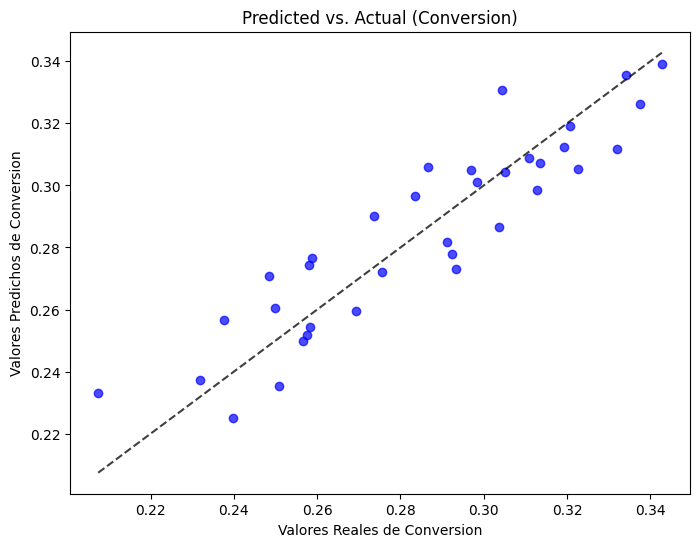

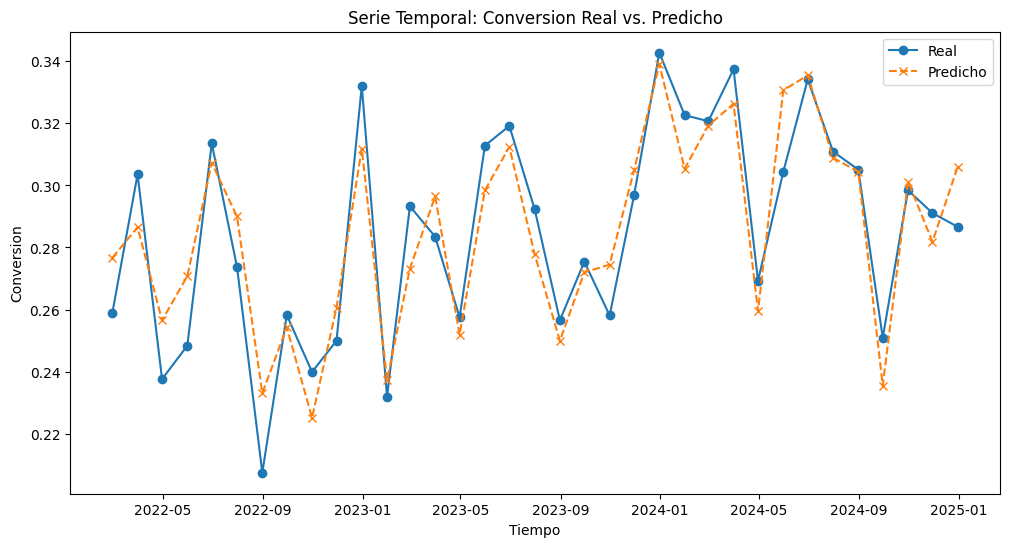

In [497]:
# =============================================================================
# 6. VISUALIZACIÓN: Scatter plot y Serie Temporal (con variables en porcentajes)
# =============================================================================
# Predicted vs. Actual Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(y_ext, y_pred_ext, color='blue', alpha=0.7)
lims = [min(y_ext.min(), y_pred_ext.min()), max(y_ext.max(), y_pred_ext.max())]
plt.plot(lims, lims, 'k--', alpha=0.75)
plt.xlabel("Valores Reales de " + target)
plt.ylabel("Valores Predichos de " + target)
plt.title("Predicted vs. Actual (" + target + ")")
plt.show()

# Time Series Plot: Actual vs. Predicted
plt.figure(figsize=(12,6))
plt.plot(df_model_ext.index, y_ext, label='Real', marker='o', linestyle='-')
plt.plot(df_model_ext.index, y_pred_ext, label='Predicho', marker='x', linestyle='--')
plt.xlabel("Tiempo")
plt.ylabel(target)
plt.title("Serie Temporal: " + target + " Real vs. Predicho")
plt.legend()
plt.show()

# SImulacion 

## Primero calculamos el presupuesto medio histórico por mes

In [498]:
# df_inv: inversiones agrupadas (valores absolutos) con columnas ["Internet", "Plataformas", "CINE", "Otros"]
df_inv = df_inv.sort_index().resample('M').sum()


# Calcular el presupuesto total mensual (suma de las inversiones en cada mes)
df_inv_total = df_inv.sum(axis=1)
# O bien, usar el promedio mensual
base_budget_real = df_inv_total.mean()
print("Presupuesto base real (promedio mensual):", base_budget_real)



Presupuesto base real (promedio mensual): 576507.565625


/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_2820/541483707.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_inv = df_inv.sort_index().resample('M').sum()


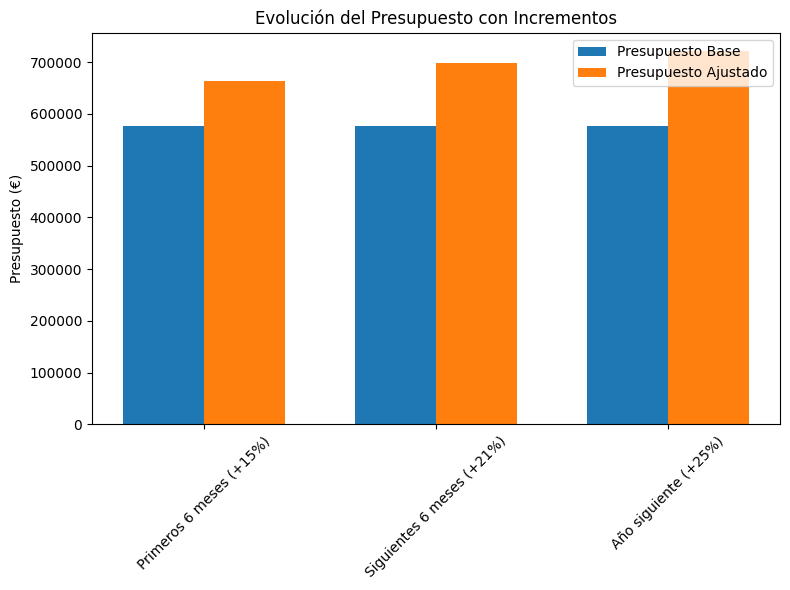

In [499]:
# ---------------------------------------------------------------------------
# SUPUESTOS:
# - "base_budget" ya se definió en la simulación usando el presupuesto real promedio.
# - "escenarios" es el diccionario que contiene los factores de incremento para cada escenario.
# ---------------------------------------------------------------------------

# Visualización: Evolución del Presupuesto con los Incrementos
escenarios_names = list(escenarios.keys())
nuevo_budget = [base_budget * escenarios[esc] for esc in escenarios_names]

fig, ax = plt.subplots(figsize=(8,6))
x = np.arange(len(escenarios_names))
width = 0.35

ax.bar(x - width/2, [base_budget]*len(x), width, label="Presupuesto Base")
ax.bar(x + width/2, nuevo_budget, width, label="Presupuesto Ajustado")
ax.set_xticks(x)
ax.set_xticklabels(escenarios_names, rotation=45)
ax.set_ylabel("Presupuesto (€)")
ax.set_title("Evolución del Presupuesto con Incrementos")
ax.legend()

plt.tight_layout()
plt.show()

In [500]:


# =============================================================================
# SUPUESTOS:
# - Se parte de tu código previo, de modo que ya se han definido:
#     X_ext = df_model_ext.drop(columns=[target])
#     y_ext = df_model_ext[target]
# - El modelo ridge_cv_ext ya está ajustado sobre X_ext e y_ext.
# - El orden en X_ext es: las primeras 4 columnas corresponden a las inversiones (en %):
#       ["Internet", "Plataformas", "Cine", "Otros"]
#   y el resto (fixed_cols) son otras variables (por ejemplo, outcome rezagado, NaturalSearch, etc.).
# - Para la simulación usaremos los valores candidatos que definas manualmente para cada canal.
# =============================================================================

# =============================================================================
# 1. SIMULACIÓN DE LA ASIGNACIÓN DE INVERSIÓN
# =============================================================================
# Escenarios de incremento de presupuesto (según el enunciado)
escenarios = {
    "Primeros 6 meses (+15%)": 1.15,
    "Siguientes 6 meses (+21%)": 1.21,
    "Año siguiente (+25%)": 1.25
}

# Presupuesto base (valor arbitrario, por ejemplo, 100 unidades)
base_budget = base_budget_real

# Valores candidatos para cada uno de los 4 canales. 
# Puedes definirlos de forma independiente para tener mayor control.
cand_internet    = [20,25,50,70,90,100]
cand_plataformas = [20,25,50,70,90,100]
cand_cine        = [5,10,20]
cand_otros       = [5,10,20]

# Extra: Obtener los valores medios de las variables fijas (las que no son inversión)
investment_cols = ["Internet", "Plataformas", "Cine", "Otros"]
fixed_cols = [col for col in X_ext.columns if col not in investment_cols]
fixed_means = X_ext[fixed_cols].mean().values  # Esto nos dará un vector (n_fijos,)

# Lista para almacenar los resultados de la simulación
resultados_sim = []

# Usamos bucles anidados para iterar sobre cada candidato definido para cada canal.
# Sólo se aceptan las combinaciones en las que la suma de las asignaciones en los 4 canales sea igual a 100 (100%).
for esc, factor in escenarios.items():
    nuevo_budget = base_budget * factor  # Incremento del presupuesto según el escenario
    # Iteramos manualmente sobre cada canal:
    for inv in cand_internet:
        for plat in cand_plataformas:
            for cine in cand_cine:
                for otros in cand_otros:
                    if inv + plat + cine + otros == 100:
                        # Creamos el vector candidato para las inversiones
                        candidato = np.array([inv, plat, cine, otros])
                        # El vector completo de predictores se construye concatenando
                        # las inversiones (candidatas) y los valores medios de las variables fijas.
                        vector_pred = np.concatenate([candidato, fixed_means])
                        # Predicción del modelo: Y = intercepto + suma(beta_i * X_i)
                        pred = ridge_cv_ext.intercept_ + np.dot(ridge_cv_ext.coef_, vector_pred)
                        # Ajustamos la prediccion según el incremento presupuestario.
                        # La idea es que, si se incrementa el presupuesto, se amplifica el efecto.
                        pred_ajustada = pred * (nuevo_budget / base_budget)
                        
                        resultados_sim.append({
                            "Escenario": esc,
                            "Internet": inv,
                            "Plataformas": plat,
                            "Cine": cine,
                            "Otros": otros,
                            "Prediccion": pred_ajustada
                        })

# Convertir los resultados en DataFrame y ordenarlo por la Prediccion (de mayor a menor)
df_sim = pd.DataFrame(resultados_sim)
df_sim = df_sim.sort_values("Prediccion", ascending=False)
print("\n--- Top 10 simulaciones ---")
print(df_sim.head(10))




--- Top 10 simulaciones ---
               Escenario  Internet  Plataformas  Cine  Otros  Prediccion
29  Año siguiente (+25%)        70           20     5      5    0.363904
27  Año siguiente (+25%)        50           25     5     20    0.362076
25  Año siguiente (+25%)        50           20    10     20    0.361359
26  Año siguiente (+25%)        50           20    20     10    0.358531
28  Año siguiente (+25%)        50           25    20      5    0.357835
23  Año siguiente (+25%)        25           50     5     20    0.357180
20  Año siguiente (+25%)        20           50    10     20    0.355483
22  Año siguiente (+25%)        20           70     5      5    0.354112
24  Año siguiente (+25%)        25           50    20      5    0.352938
21  Año siguiente (+25%)        20           50    20     10    0.352656


Mejor candidato:
Escenario      Año siguiente (+25%)
Internet                         70
Plataformas                      20
Cine                              5
Otros                             5
Prediccion                 0.363904
Name: 29, dtype: object


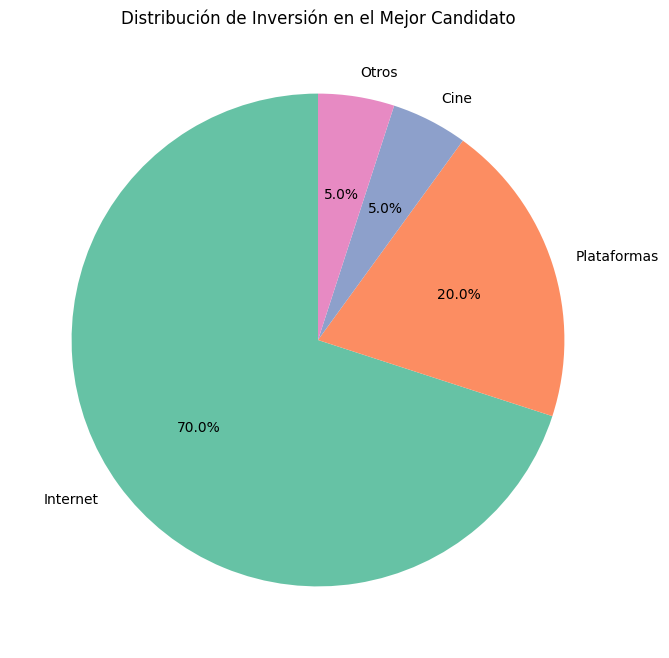

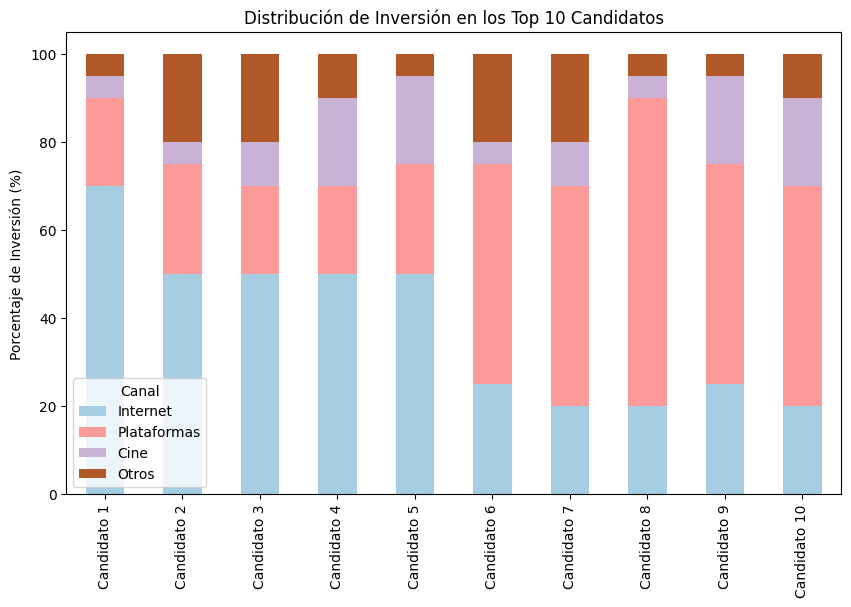

In [501]:
# ---------------------------
# Visualización A: Pie Chart del Mejor Candidato
# ---------------------------
# Extraer el candidato con mayor prediccion global
mejor_candidato = df_sim.sort_values("Prediccion", ascending=False).iloc[0]
print("Mejor candidato:")
print(mejor_candidato)

# Extraer los porcentajes para los 4 canales
porcentajes = mejor_candidato[["Internet", "Plataformas", "Cine", "Otros"]]

plt.figure(figsize=(8,8))
plt.pie(porcentajes, labels=porcentajes.index, autopct="%1.1f%%", startangle=90, 
        colors=sns.color_palette("Set2"))
plt.title("Distribución de Inversión en el Mejor Candidato")
plt.show()

# ---------------------------
# Visualización B: Stacked Bar Chart de los Top 10 Candidatos
# ---------------------------
# Seleccionar los 10 mejores candidatos por "Prediccion"
top10 = df_sim.sort_values("Prediccion", ascending=False).head(10).reset_index(drop=True)
# Asignar nombres a cada candidato
top10.index = ["Candidato " + str(i+1) for i in range(len(top10))]

# Extraer las columnas de inversión
top10_inversion = top10[["Internet", "Plataformas", "Cine", "Otros"]]

# Graficar barras apiladas
top10_inversion.plot(kind="bar", stacked=True, figsize=(10,6), colormap="Paired")
plt.ylabel("Porcentaje de Inversión (%)")
plt.title("Distribución de Inversión en los Top 10 Candidatos")
plt.legend(title="Canal")
plt.show()

Top 2 candidatos:
              Escenario  Internet  Plataformas  Cine  Otros  Prediccion
0  Año siguiente (+25%)        70           20     5      5    0.363904
1  Año siguiente (+25%)        50           25     5     20    0.362076


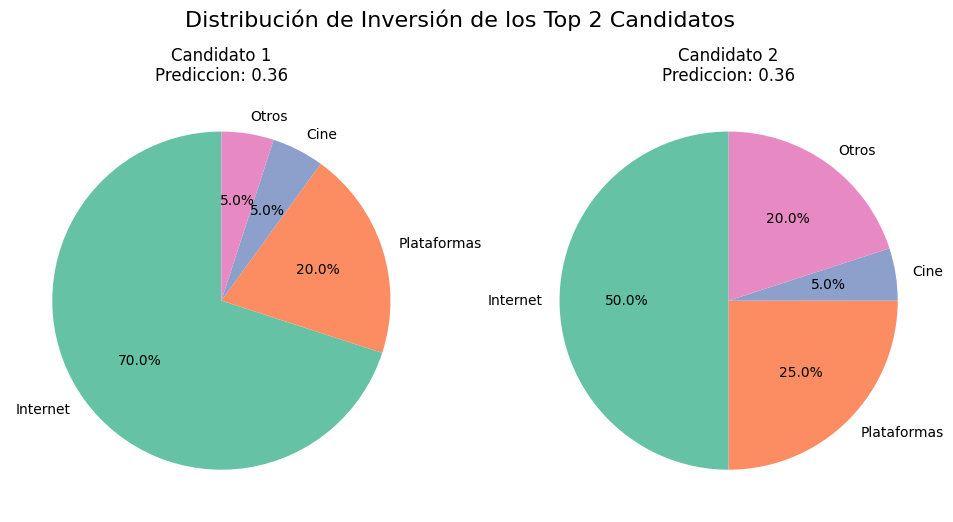

/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_2820/163844022.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Candidato 1", "Candidato 2"], y=top2["Prediccion"], palette="coolwarm")


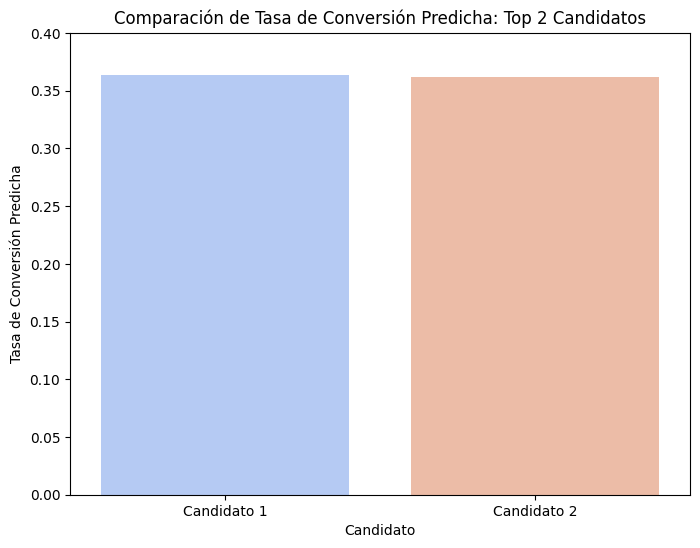

In [502]:
# Supongamos que ya tienes el DataFrame de simulación df_sim,
# donde cada fila tiene las columnas: 
# "Escenario", "Internet", "Plataformas", "Cine", "Otros" y "Prediccion"

# Extraer los dos mejores candidatos (aquellos con mayor "Prediccion")
top2 = df_sim.sort_values("Prediccion", ascending=False).head(2).reset_index(drop=True)
print("Top 2 candidatos:")
print(top2)

# ---------------------------
# Visualización 1: Panel de Pie Charts para los Top 2 Candidatos
# ---------------------------
fig, axs = plt.subplots(1, 2, figsize=(12,6))
for i in range(2):
    # Extraemos la asignación de inversión para el candidato i
    asignacion = top2.loc[i, ["Internet", "Plataformas", "Cine", "Otros"]]
    axs[i].pie(asignacion, labels=asignacion.index, autopct="%1.1f%%", startangle=90,
               colors=sns.color_palette("Set2"))
    axs[i].set_title(f"Candidato {i+1}\nPrediccion: {top2.loc[i, 'Prediccion']:.2f}")
fig.suptitle("Distribución de Inversión de los Top 2 Candidatos", fontsize=16)
plt.show()

# ---------------------------
# Visualización 2: Bar Plot Comparativo de la Tasa de Conversión Predicha
# ---------------------------
plt.figure(figsize=(8,6))
sns.barplot(x=["Candidato 1", "Candidato 2"], y=top2["Prediccion"], palette="coolwarm")
plt.xlabel("Candidato")
plt.ylabel("Tasa de Conversión Predicha")
plt.title("Comparación de Tasa de Conversión Predicha: Top 2 Candidatos")
plt.ylim(0, top2["Prediccion"].max()*1.1)  # Para darle algo de espacio arriba
plt.show()

Top 2 candidatos:
               Escenario  Internet  Plataformas  Cine  Otros  Prediccion
29  Año siguiente (+25%)        70           20     5      5    0.363904
27  Año siguiente (+25%)        50           25     5     20    0.362076

Gastos en euros para los dos mejores candidatos:
               Escenario  Internet  Plataformas  Cine  Otros    NuevoBudget  \
29  Año siguiente (+25%)        70           20     5      5  720634.457031   
27  Año siguiente (+25%)        50           25     5     20  720634.457031   

    Gasto_Internet  Gasto_Plataformas    Gasto_Cine    Gasto_Otros  
29   504444.119922      144126.891406  36031.722852   36031.722852  
27   360317.228516      180158.614258  36031.722852  144126.891406  


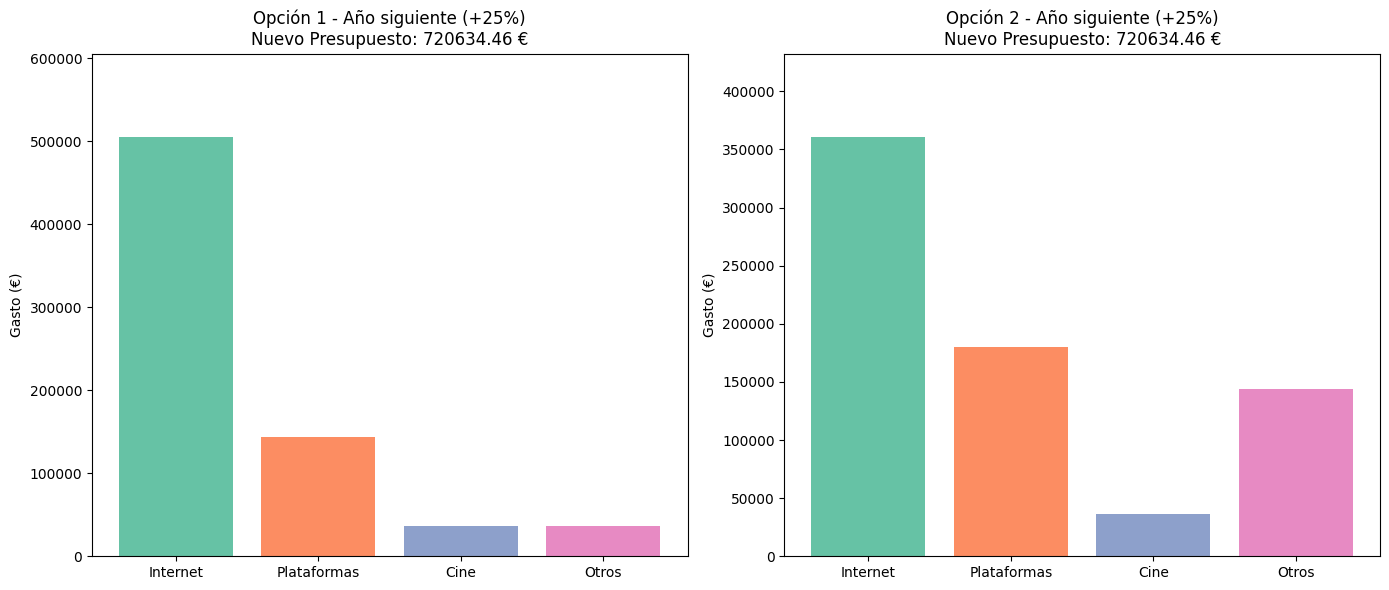

In [503]:
# Supongamos que ya tienes df_sim, en el que cada fila tiene las columnas:
# "Escenario", "Internet", "Plataformas", "Cine", "Otros" y "Prediccion"
# Además, se tiene base_budget definido como base_budget_real (el presupuesto base real promedio)

# Extraer los dos mejores candidatos (según la columna "Prediccion")
top2 = df_sim.sort_values("Prediccion", ascending=False).head(2).copy()
print("Top 2 candidatos:")
print(top2)

# Mapear cada escenario a su factor de incremento (ya definido en la simulación)
escenarios = {
    "Primeros 6 meses (+15%)": 1.15,
    "Siguientes 6 meses (+21%)": 1.21,
    "Año siguiente (+25%)": 1.25
}
top2["Factor"] = top2["Escenario"].map(escenarios)
top2["NuevoBudget"] = base_budget * top2["Factor"]

# Calcular el gasto en euros para cada canal:
for canal in ["Internet", "Plataformas", "Cine", "Otros"]:
    top2[f"Gasto_{canal}"] = (top2[canal] / 100) * top2["NuevoBudget"]

print("\nGastos en euros para los dos mejores candidatos:")
print(top2[["Escenario", "Internet", "Plataformas", "Cine", "Otros", 
            "NuevoBudget", "Gasto_Internet", "Gasto_Plataformas", "Gasto_Cine", "Gasto_Otros"]])

# Visualización: Gráfico de barras para cada una de las dos mejores opciones
fig, ax = plt.subplots(1, 2, figsize=(14,6))
canales = ["Internet", "Plataformas", "Cine", "Otros"]
for i, (_, row) in enumerate(top2.iterrows()):
    gastos = [row[f"Gasto_{canal}"] for canal in canales]
    ax[i].bar(canales, gastos, color=sns.color_palette("Set2"))
    ax[i].set_title(f"Opción {i+1} - {row['Escenario']}\nNuevo Presupuesto: {row['NuevoBudget']:.2f} €")
    ax[i].set_ylabel("Gasto (€)")
    ax[i].set_ylim(0, max(gastos)*1.2)
plt.tight_layout()
plt.show()

Mejores candidatos por escenario:
                    Escenario  Internet  Plataformas  Cine  Otros  Prediccion
29       Año siguiente (+25%)        70           20     5      5    0.363904
9     Primeros 6 meses (+15%)        70           20     5      5    0.334792
19  Siguientes 6 meses (+21%)        70           20     5      5    0.352259


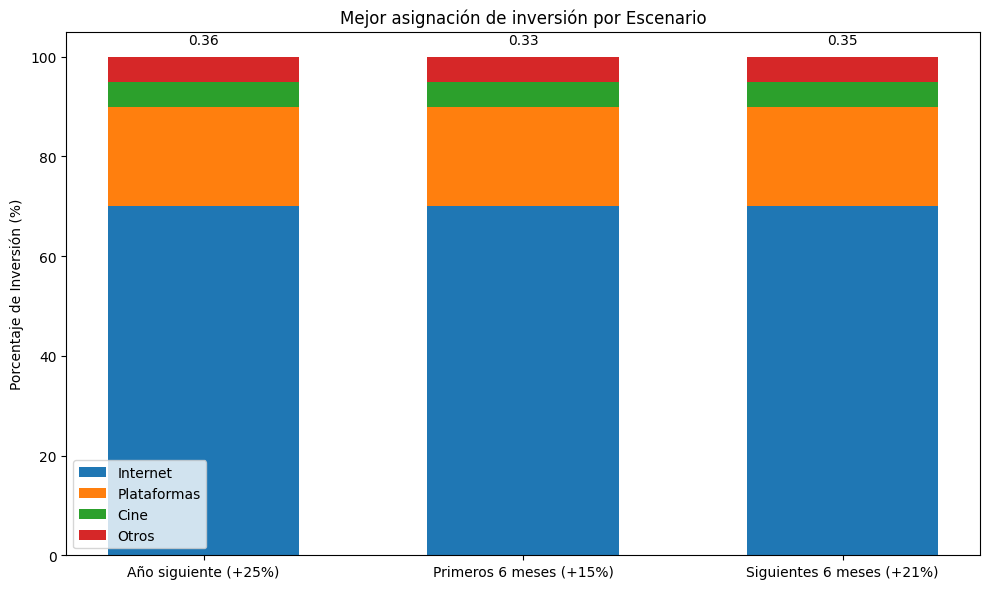

In [504]:
# Seleccionar el mejor candidato (máxima predicción) por escenario
mejores_por_esc = df_sim.loc[df_sim.groupby("Escenario")["Prediccion"].idxmax()].copy()
print("Mejores candidatos por escenario:")
print(mejores_por_esc)

# Crear gráfico de barras apiladas para visualizar la distribución de inversión por escenario
colores = {"Internet": "#1f77b4", "Plataformas": "#ff7f0e", "Cine": "#2ca02c", "Otros": "#d62728"}

escenarios_list = mejores_por_esc["Escenario"].tolist()
x = np.arange(len(escenarios_list))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))
# Extraer los porcentajes para cada canal
internet_vals    = mejores_por_esc["Internet"].values
plataformas_vals = mejores_por_esc["Plataformas"].values
cine_vals        = mejores_por_esc["Cine"].values
otros_vals       = mejores_por_esc["Otros"].values

# Crear las barras apiladas
p4 = ax.bar(x, internet_vals, width, color=colores["Internet"], label="Internet")
p3 = ax.bar(x, plataformas_vals, width, bottom=internet_vals, color=colores["Plataformas"], label="Plataformas")
p2 = ax.bar(x, cine_vals, width, bottom=internet_vals+plataformas_vals, color=colores["Cine"], label="Cine")
p1 = ax.bar(x, otros_vals, width, bottom=internet_vals+plataformas_vals+cine_vals, color=colores["Otros"], label="Otros")

ax.set_ylabel("Porcentaje de Inversión (%)")
ax.set_title("Mejor asignación de inversión por Escenario")
ax.set_xticks(x)
ax.set_xticklabels(escenarios_list, rotation=0)
ax.legend()

# Agregar el valor de la predicción encima de cada barra
for i, (_, row) in enumerate(mejores_por_esc.iterrows()):
    total = row["Internet"] + row["Plataformas"] + row["Cine"] + row["Otros"]  # Debe ser 100
    ax.text(x[i], total + 2, f"{row['Prediccion']:.2f}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

Visitantes promedio: 6110.833333333333
Ticket medio (€/venta): 0.2841447338515387

Mejor candidato:
Escenario      Año siguiente (+25%)
Internet                         70
Plataformas                      20
Cine                              5
Otros                             5
Prediccion                 0.363904
Factor                         1.25
NuevoBudget           720634.457031
Name: 29, dtype: object
Factor del escenario: 1.25
Predicción base (a presupuesto base): 0.29112333336111507

Simulación de ingresos:
   Multiplicador    Presupuesto  Conversion       Ventas    Ingresos
0       1.000000  576507.565625    0.291123  1779.006170  505.495235
1       1.026316  591678.817352    0.298784  1825.822121  518.797741
2       1.052632  606850.069079    0.306446  1872.638073  532.100247
3       1.078947  622021.320806    0.314107  1919.454025  545.402753
4       1.105263  637192.572533    0.321768  1966.269977  558.705259


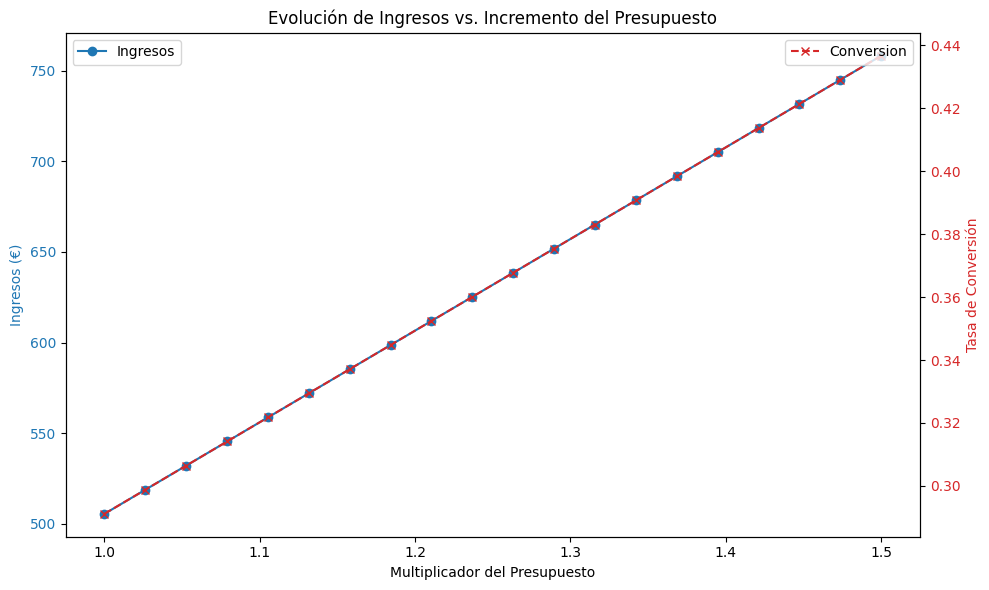

In [505]:
df_sim["Factor"] = df_sim["Escenario"].map(escenarios)
df_sim["NuevoBudget"] = base_budget * df_sim["Factor"]

visitantes_promedio = df_visit_store["Visit_Store"].mean()
ticket_medio = (df_sales["Sales"].sum() / df_visit_store["Visit_Store"].sum())

print("Visitantes promedio:", visitantes_promedio)
print("Ticket medio (€/venta):", ticket_medio)

# --- 1. Seleccionar el Mejor Candidato de la Simulación ---
# Usamos la columna "Prediccion" (sin tilde) como resultado del modelo ajustado
best_candidate = df_sim.sort_values("Prediccion", ascending=False).iloc[0]
# En este candidato, el presupuesto ya fue incrementado según el escenario:
factor_candidate = best_candidate["NuevoBudget"] / base_budget  
# Por lo tanto, la predicción base (a presupuesto base) se obtiene dividiendo:
pred_base = best_candidate["Prediccion"] / factor_candidate

print("\nMejor candidato:")
print(best_candidate)
print("Factor del escenario:", factor_candidate)
print("Predicción base (a presupuesto base):", pred_base)

# --- 2. Simular la Evolución del Retorno (Ingresos) al Incrementar el Presupuesto ---
# Definimos un rango de multiplicadores para el presupuesto (por ejemplo, de 1.0 a 1.5)
multiplicadores = np.linspace(1.0, 1.5, 20)
# Listas para almacenar resultados
conversion_list = []   # Tasa de conversión simulada
sales_list = []        # Ventas simuladas (número de ventas)
ingresos_list = []     # Ingresos simulados (en euros)
budget_list = []       # Presupuesto en euros

for m in multiplicadores:
    # Nuevo presupuesto
    presupuesto_nuevo = base_budget * m
    budget_list.append(presupuesto_nuevo)
    # La predicción (tasa de conversión) se escala linealmente: 
    conversion_sim = pred_base * m  
    conversion_list.append(conversion_sim)
    # Supongamos que el número de visitantes se mantiene constante (visitantes_promedio)
    ventas_sim = conversion_sim * visitantes_promedio
    sales_list.append(ventas_sim)
    # Ingresos simulados = ventas * ticket_medio
    ingresos_sim = ventas_sim * ticket_medio
    ingresos_list.append(ingresos_sim)

# Convertir resultados a DataFrame para graficar
df_sim_curve = pd.DataFrame({
    "Multiplicador": multiplicadores,
    "Presupuesto": budget_list,
    "Conversion": conversion_list,
    "Ventas": sales_list,
    "Ingresos": ingresos_list
})

print("\nSimulación de ingresos:")
print(df_sim_curve.head())

# --- 3. Visualización de la Evolución ---
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:blue'
ax1.set_xlabel("Multiplicador del Presupuesto")
ax1.set_ylabel("Ingresos (€)", color=color)
ax1.plot(df_sim_curve["Multiplicador"], df_sim_curve["Ingresos"], marker='o', color=color, label="Ingresos")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Evolución de Ingresos vs. Incremento del Presupuesto")
ax1.legend(loc="upper left")

# También podemos graficar la tasa de conversión en un eje secundario
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel("Tasa de Conversión", color=color)
ax2.plot(df_sim_curve["Multiplicador"], df_sim_curve["Conversion"], marker='x', linestyle="--", color=color, label="Conversion")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()